In [64]:
%matplotlib inline
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [65]:
# Load Fashine MNIST
(X_train, y_train0), (X_test, y_test0) = datasets.fashion_mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [66]:
#定義函數
enc_1 = Dense(200, activation='sigmoid')
enc_2= Dense(50, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(50, activation='sigmoid')
dec_1 = Dense(200, activation='sigmoid')
dec_0= Dense(784, activation='sigmoid')

In [67]:
#定義encoder變數
x = Input(shape=(784,))
enc_1_x = enc_1(x)
enc_2_x = enc_2(enc_1_x)

z_mean = enc_mean(enc_2_x)
z_log_var = enc_log_var(enc_2_x)

In [68]:
#進行抽樣分配
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [69]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [70]:
# 定義decoder變數
z_input = Input(shape=(2,))
x_hat= dec_0(dec_1(dec_2(z_input)))

In [71]:
#組裝
x_hat =dec_0(dec_1(dec_2(z)))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 200)          157000      input_13[0][0]                   
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 50)           10050       dense_40[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 2)            102         dense_41[0][0]                   
____________________________________________________________________________________________

In [72]:
#Loss函數建立
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [73]:
VAE.compile(optimizer=Adam())

In [74]:
#訓練VAE
VAE.fit([X_train, X_train], 
        batch_size=128, 
        epochs=5)

VAE.save_weights('VAE_handwriting_model_weights.h5')

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 90us/sample - loss: 63.3617
Epoch 2/5
60000/60000 [==============================] - 4s 67us/sample - loss: 50.2784
Epoch 3/5
60000/60000 [==============================] - 4s 66us/sample - loss: 38.9119
Epoch 4/5
60000/60000 [==============================] - 5s 90us/sample - loss: 35.0231
Epoch 5/5
60000/60000 [==============================] - 6s 105us/sample - loss: 33.4681


In [75]:
#VAE 的視覺化呈現
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_40 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_41 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 102       
Total params: 167,152
Trainable params: 167,152
Non-trainable params: 0
_________________________________________________________________


In [79]:
VAE_Decoder = Model(z_input, dec_0(dec_1(dec_2(z_input))))

VAE_Decoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_44 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_45 (Dense)             (None, 200)               10200     
_________________________________________________________________
dense_46 (Dense)             (None, 784)               157584    
Total params: 167,934
Trainable params: 167,934
Non-trainable params: 0
_________________________________________________________________


In [80]:
# Encoder 的視覺化呈現
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 22747 圖的 latent 表示為 [-0.11356808 -1.6872146 ]


In [83]:
indices = np.random.randint(X_train.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(X_train[indices])

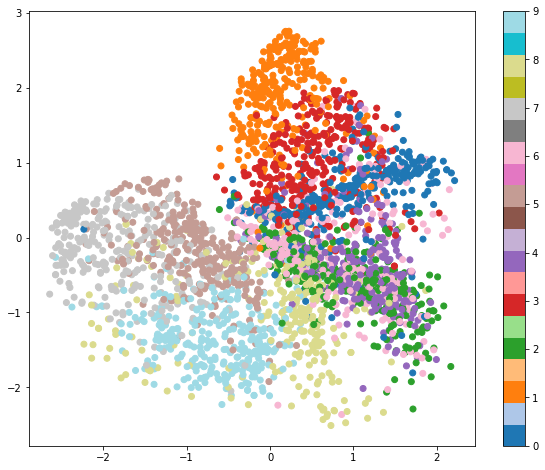

In [84]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

In [85]:
#Decoder 的視覺化呈現
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [87]:
n = 30
digit_size = 28
grid_x_vae = np.linspace(-3+0.05, 3-0.05, n)
grid_y_vae = np.linspace(-3+0.05, 3-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

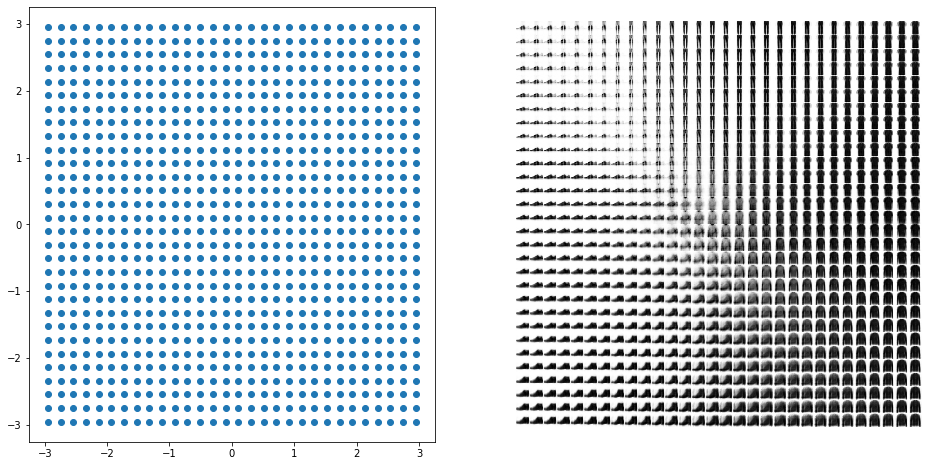

In [94]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

In [95]:
#動態比較
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [96]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [97]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>